In [118]:
import torch
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

## PartImageNet

In [2]:
proportion = torch.load("../partImageNet_proportion.pt")

In [3]:
proportion_statistics = pd.DataFrame(
    {
        "proportion":[i[0] for i in list(proportion.values())],
        "key": list(proportion.keys())
    }
)

In [114]:
result_bn = torch.load("PatchGuard/result_bn.pt")
result_vit = torch.load("../result_vit_48.pt")
result_ds = torch.load("PatchGuard/ds_result.pt")

In [127]:
def get_region_certified_accuracy_bn(proportion, statistics, record, region):
    certification_result = torch.tensor(record["certification_result"])
    lower = statistics["proportion"].quantile(region[0])
    upper = statistics["proportion"].quantile(region[1])
    proportion_list = torch.tensor([proportion[i][0] for i in record["file_list"]])
    index = torch.bitwise_and(lower <= proportion_list, proportion_list <= upper)
    robust = certification_result[index]
    acc = torch.tensor(record['acc_with_defense'])[index]
    return float(torch.sum(robust == 2) / len(robust)), float(torch.sum(acc == True)) / len(robust)

def get_region_certified_accuracy_ds(proportion, statistics, record, region):
    certification_result = torch.tensor(record["cert_correct_list"])
    lower = statistics["proportion"].quantile(region[0])
    upper = statistics["proportion"].quantile(region[1])
    proportion_list = torch.tensor([proportion[i][0] for i in record["file_list"]])
    index = torch.bitwise_and(lower <= proportion_list, proportion_list <= upper)
    robust = certification_result[index]
    acc = torch.tensor(record['correct_list'])[index]
    return float(torch.sum(robust == 1) / len(robust)), float(torch.sum(acc == True)) / len(robust)

def get_region_certified_accuracy_vit(proportion, statistics, record, region):
    certification_result = torch.tensor(record["verified_correct_list"])
    lower = statistics["proportion"].quantile(region[0])
    upper = statistics["proportion"].quantile(region[1])
    proportion_list = torch.tensor([proportion[i[0]][0] for i in record["file_list"]])
    index = torch.bitwise_and(lower <= proportion_list, proportion_list <= upper)
    robust = certification_result[index]
    acc = torch.tensor(record['correct_list'])[index]
    return float(torch.sum(robust == 1) / len(robust)), float(torch.sum(acc == True)) / len(robust)

In [157]:
x = list()
bn = list()
ds = list()
vit = list()
for i in range(5):
    region = (i*0.2, (i+1)*0.2)
    x.append(region[1])
    bn.append(get_region_certified_accuracy_bn(proportion, proportion_statistics, result_bn, region)[0])
    ds.append(get_region_certified_accuracy_ds(proportion, proportion_statistics, result_ds, region)[0])
    vit.append(get_region_certified_accuracy_vit(proportion, proportion_statistics, result_vit, region)[0])

/tmp/ipykernel_15003/3926654967.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  acc = torch.tensor(record['acc_with_defense'])[index]


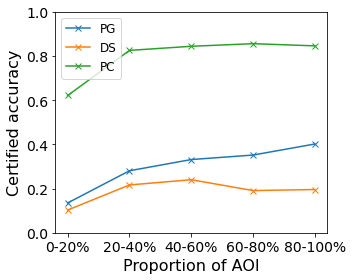

In [158]:
plt.figure(figsize=(5, 4))
plt.plot(x, bn, marker="x", label="PG")
plt.plot(x, ds, marker="x", label="DS")
plt.plot(x, vit, marker="x", label="PC")
plt.xticks(x, ["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"])
plt.ylabel("Certified accuracy", fontsize=16)
plt.xlabel("Proportion of AOI", fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()
plt.savefig("partimageNet_certified.jpg", dpi=300)

In [133]:
x = list()
bn = list()
ds = list()
vit = list()
for i in range(5):
    region = (i*0.2, (i+1)*0.2)
    x.append(region[1])
    bn.append(get_region_certified_accuracy_bn(proportion, proportion_statistics, result_bn, region)[1])
    ds.append(get_region_certified_accuracy_ds(proportion, proportion_statistics, result_ds, region)[1])
    vit.append(get_region_certified_accuracy_vit(proportion, proportion_statistics, result_vit, region)[1])

/tmp/ipykernel_15003/3926654967.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  acc = torch.tensor(record['acc_with_defense'])[index]


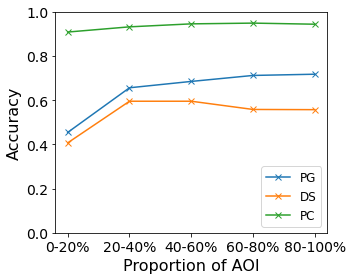

In [137]:
plt.figure(figsize=(5, 4))
plt.plot(x, bn, marker="x", label="PG")
plt.plot(x, ds, marker="x", label="DS")
plt.plot(x, vit, marker="x", label="PC")
plt.xticks(x, ["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"])
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Proportion of AOI", fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.savefig("partimageNet.jpg", dpi=300)

## ImageNet with bounding box

In [32]:
import torchvision
import re
import pandas as pd

In [108]:
dataset = ImageFolder(
                "imagenet2012/validation",
            )

In [159]:
loc_val = pd.read_csv("bounding_box_ImageNet/LOC_val_solution.csv")

In [249]:
name_result_mapping = dict()
def compute_area(xyxy):
    x_min = min(xyxy[0], xyxy[2])
    x_max = max(xyxy[0], xyxy[2])
    y_min = min(xyxy[1], xyxy[3])
    y_max = max(xyxy[1], xyxy[3])
    return (y_max - y_min) * (x_max - x_min)

for row in loc_val.iterrows():
    area_info = row[1]["PredictionString"]
    area_info = re.split("n[0-9]*\S", area_info)
    max_computed_area = 0
    for area in area_info:
        if len(area) == 0:
            continue
        computed_area = compute_area([int(i) for i in area.strip().split(" ")])
        if max_computed_area < computed_area:
            max_computed_area = computed_area
    name_result_mapping[row[1]["ImageId"]] = [max_computed_area]

In [250]:
for idx, img in enumerate(tqdm.tqdm(dataset)):
    img_size = img[0].size
    file_loc = dataset.samples[idx][0].split("/")[-1].split(".")[0]
    name_result_mapping[file_loc].append(img_size[0] * img_size[1])

100%|██████████| 50000/50000 [05:34<00:00, 149.64it/s]


In [91]:
loc_id_set = set(loc_val["ImageId"])

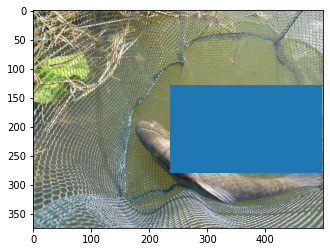

In [213]:
plt.imshow(dataset[0][0])
plt.gca().add_patch(plt.Rectangle([236, 129], 498-236, 280-129))

In [252]:
!ls ../

cocoapi			    PatchGuard	       train
data_loaders.py		    __pycache__        train.py
LICENSE			    README.md	       train_vit.sh
log_analyzer.py		    results	       utils.py
mask_part.log		    result_vit_48.pt   vision_transformer.py
output			    temp_save	       vit_evael.log
partImageNet_proportion.pt  test_empirical.py  vit_finetune.log
partImagenet_result_vit.pt  test_script.sh
patch_attack.py		    test_verified.py


In [277]:
result_bn = torch.load("PatchGuard/result_bn_imagenet_val.pt")
result_vit = torch.load("../../result_vit_imagenet_val.pt")
result_ds = torch.load("PatchGuard/result_ds_imagenet_val.pt")

In [258]:
file_set = set()
for file in result_bn["file_list"]:
    file_set.add(file.split("/")[-1].split(".")[0])

In [262]:
sub_mapping = dict()
for file_loc in name_result_mapping:
    if file_loc in file_set:
        sub_mapping[file_loc] = name_result_mapping[file_loc][0] / name_result_mapping[file_loc][1]

In [264]:
proportion_statistics = pd.DataFrame(
    {
        "proportion":[i for i in list(sub_mapping.values())],
        "key": list(sub_mapping.keys())
    }
)

In [269]:
def get_region_certified_accuracy_bn(proportion, statistics, record, region):
    certification_result = torch.tensor(record["certification_result"])
    lower = statistics["proportion"].quantile(region[0])
    upper = statistics["proportion"].quantile(region[1])
    proportion_list = torch.tensor([proportion[i.split("/")[-1].split(".")[0]] for i in record["file_list"]])
    index = torch.bitwise_and(lower <= proportion_list, proportion_list <= upper)
    robust = certification_result[index]
    acc = torch.tensor(record['acc_with_defense'])[index]
    return float(torch.sum(robust == 2) / len(robust)), float(torch.sum(acc == True)) / len(robust)

def get_region_certified_accuracy_ds(proportion, statistics, record, region):
    certification_result = torch.tensor(record["cert_correct_list"])
    lower = statistics["proportion"].quantile(region[0])
    upper = statistics["proportion"].quantile(region[1])
    proportion_list = torch.tensor([proportion[i.split("/")[-1].split(".")[0]] for i in record["file_list"]])
    index = torch.bitwise_and(lower <= proportion_list, proportion_list <= upper)
    robust = certification_result[index]
    acc = torch.tensor(record['correct_list'])[index]
    return float(torch.sum(robust == 1) / len(robust)), float(torch.sum(acc == True)) / len(robust)

def get_region_certified_accuracy_vit(proportion, statistics, record, region):
    certification_result = torch.tensor(record["verified_correct_list"])
    lower = statistics["proportion"].quantile(region[0])
    upper = statistics["proportion"].quantile(region[1])
    proportion_list = torch.tensor([proportion[i[0].split("/")[-1].split(".")[0]] for i in record["file_list"]])
    index = torch.bitwise_and(lower <= proportion_list, proportion_list <= upper)
    robust = certification_result[index]
    acc = torch.tensor(record['correct_list'])[index]
    return float(torch.sum(robust == 1) / len(robust)), float(torch.sum(acc == True)) / len(robust)

In [279]:
x = list()
bn = list()
ds = list()
vit = list()
for i in range(5):
    region = (i*0.2, (i+1)*0.2)
    x.append(region[1])
    bn.append(get_region_certified_accuracy_bn(sub_mapping, proportion_statistics, result_bn, region)[0])
    ds.append(get_region_certified_accuracy_ds(sub_mapping, proportion_statistics, result_ds, region)[0])
    vit.append(get_region_certified_accuracy_vit(sub_mapping, proportion_statistics, result_vit, region)[0])

/tmp/ipykernel_15003/2207658099.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  acc = torch.tensor(record['acc_with_defense'])[index]


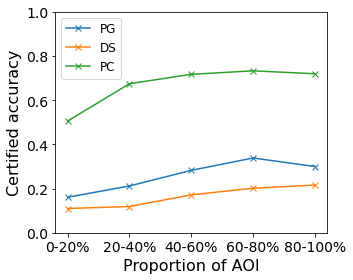

In [280]:
plt.figure(figsize=(5, 4))
plt.plot(x, bn, marker="x", label="PG")
plt.plot(x, ds, marker="x", label="DS")
plt.plot(x, vit, marker="x", label="PC")
plt.xticks(x, ["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"])
plt.ylabel("Certified accuracy", fontsize=16)
plt.xlabel("Proportion of AOI", fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()
plt.savefig("imageNet_box_certified.jpg", dpi=300)

In [281]:
x = list()
bn = list()
ds = list()
vit = list()
for i in range(5):
    region = (i*0.2, (i+1)*0.2)
    x.append(region[1])
    bn.append(get_region_certified_accuracy_bn(sub_mapping, proportion_statistics, result_bn, region)[1])
    ds.append(get_region_certified_accuracy_ds(sub_mapping, proportion_statistics, result_ds, region)[1])
    vit.append(get_region_certified_accuracy_vit(sub_mapping, proportion_statistics, result_vit, region)[1])

/tmp/ipykernel_15003/2207658099.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  acc = torch.tensor(record['acc_with_defense'])[index]


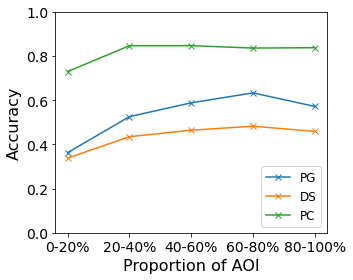

In [282]:
plt.figure(figsize=(5, 4))
plt.plot(x, bn, marker="x", label="PG")
plt.plot(x, ds, marker="x", label="DS")
plt.plot(x, vit, marker="x", label="PC")
plt.xticks(x, ["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"])
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Proportion of AOI", fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.savefig("imagenet_box.jpg", dpi=300)